### Problem: How do movie genres and release dates affect movie ratings?

You are required to show your working codes for the following tasks. 
1.	Prepare and join datasets as you see required to analyze the problem. 
2.	Explore the datasets in the context of the problem outlined. E.g. provide summary statistics, visuals, and any other relevant information
3.	Generate insights with your preferred method of analysis (e.g. machine learning, regression studies, visual analysis, etc.)
4.	Write a short summary (max. 500 words) of your findings, and generate supporting visuals. 

------

In [357]:
#import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import datetime
import numpy as np 
import re
import os
import string as str

## Preparing, joining datasets

After glancing at the provided datasets I decided that I would only be using information from ``movies.csv`` and ``ratings.csv`` for this assessment. Although the tag data could potentially interesting information, **complete this sentence**  and I doubt I could extract reliable insights from them in the context of this assignment. 

```
>>> tags = pd.read_csv('tags.csv')
>>> tags['tag'].value_counts()
In Netflix queue     131
atmospheric           36
superhero             24
thought-provoking     24
surreal               23
                    ... 
special effects        1
monologue              1
Wesley Snipes          1
Nicolas Cage           1
Canada                 1
Name: tag, Length: 1589, dtype: int64
```

The timestamp provided in the raw data seems to correspond to the time of the review/rating, rather than the release date. Therefore, I extract the release date from the title column by performing a regex search for numbers between brackets (and selecting the final result, given that some  movies had numbers within brackets in their title). There was roughly a dozen entries that did not contain a release year in the title name, which were dropped before I did the search. 

Note that I generated two data-frames which deal with genre differently (dummy variables vs exploded)

In [326]:
movies = pd.read_csv('movies.csv')
movies_dumb = movies.copy()
ratings = pd.read_csv('ratings.csv')


movies_dumb= pd.concat([movies_dumb,movies_dumb['genres'].str.get_dummies()],axis=1)
movies=movies[~movies['genres'].str.contains('no genres listed')]
movies_dumb=movies_dumb[~movies_dumb['genres'].str.contains('no genres listed')]
movies_dumb = movies_dumb.drop(['genres','(no genres listed)'],axis=1)
movies= movies[movies['title'].str.contains('\(')]
movies_dumb = movies_dumb[movies_dumb['title'].str.contains('\(')]
movies['release'] =  movies['title'].apply(lambda x: re.compile(r"\((\d+)\)").findall(x)[-1])
movies_dumb['release'] = movies_dumb['title'].apply(lambda x: re.compile(r"\((\d+)\)").findall(x)[-1])

movies['genres'] = movies.genres.str.split('|')
movies = movies.explode('genres')

ratings['timestamp']=ratings['timestamp'].apply(lambda x: int(datetime.datetime.fromtimestamp(x).year))

mr= pd.merge(left=ratings, right=movies, how='left',
                       left_on='movieId', 
                       right_on='movieId')
mr = mr.dropna()
mr['release']= mr['release'].astype(int)

mdr= pd.merge(left=ratings, right=movies_dumb, how='left',
                       left_on='movieId', 
                       right_on='movieId')

mdr = mdr.dropna()
mdr['release']= mdr['release'].astype(int)

In [73]:
mr.head()

,userId,movieId,rating,timestamp,title,genres,release
0,1,1,4.0,2000,Toy Story (1995),Adventure,1995
1,1,1,4.0,2000,Toy Story (1995),Animation,1995
2,1,1,4.0,2000,Toy Story (1995),Children,1995
3,1,1,4.0,2000,Toy Story (1995),Comedy,1995
4,1,1,4.0,2000,Toy Story (1995),Fantasy,1995


In [74]:
mdr.head()

,userId,movieId,rating,timestamp,title,Action,Adventure,Animation,Children,Comedy,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,release
0,1,1,4.0,2000,Toy Story (1995),0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1995
1,1,3,4.0,2000,Grumpier Old Men (1995),0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1995
2,1,6,4.0,2000,Heat (1995),1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1995
3,1,47,5.0,2000,Seven (a.k.a. Se7en) (1995),0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1995
4,1,50,5.0,2000,"Usual Suspects, The (1995)",0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1995


Text(0.5, 0, 'Movie Genre')

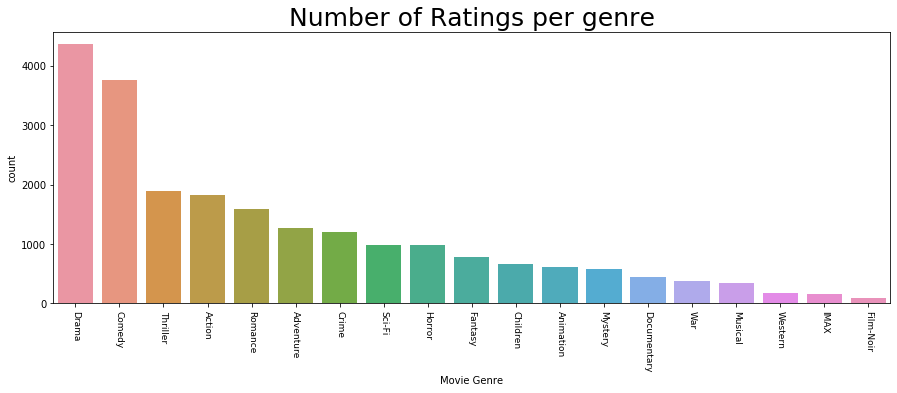

In [57]:
movies[movies.columns.to_list()[2:]].sum().sort_values()
plt.subplots(figsize=(15,5))
sns.countplot(x='genres', order = movies['genres'].value_counts().index, data=movies);
plt.xticks(rotation=-90,size=9)
plt.title('Number of Ratings per genre',size=25);
plt.xlabel('Movie Genre')

I assumed that some of these genres might be correlated with each other. If I was trying to make a regression model, I might look into this further.

Text(0.5, 1, 'Movie Genre Correlation')

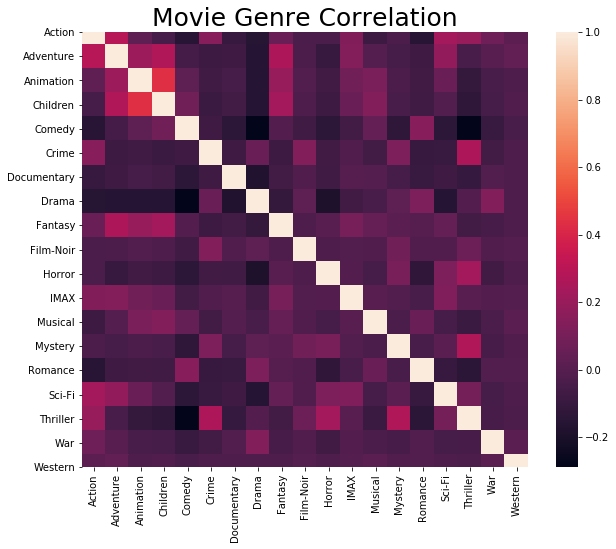

In [75]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)

ax =sns.heatmap(movies_dumb[movies_dumb.columns[2:]].corr())
plt.title('Movie Genre Correlation',size=25)

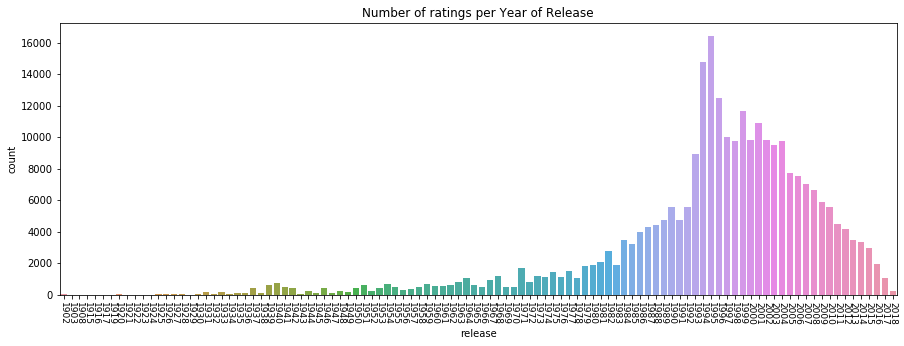

In [205]:
#mr300yr['count'].plot()
plt.subplots(figsize=(15,5))
sns.countplot(x='release', order = sorted(mr['release'].unique()), data=mr);
plt.xticks(rotation=-90,size=9)
plt.title('Number of ratings per Release Year');

1995 is the year the movie with the most amount of ratings in the database, Forest Gump, came out. Also, that there are more ratings for movies in the 90s/early 20s makes sense to me -- these movies are probably familiar to many internet users. No one is able to see every movie as soon as it comes out, so it makes sense that movies that released more recently have fewer reviews (furthermore, older movies have had more time to get more reviews 'added on'). 

I also thought  would be interesting to look at the number of different films in a year vs number of ratings in that year. 

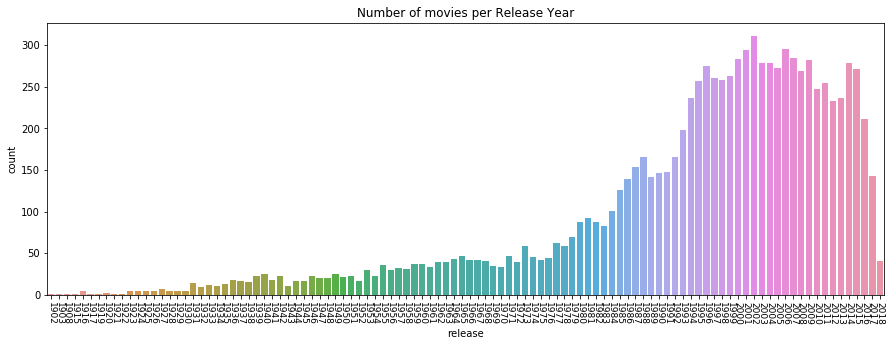

In [221]:
plt.subplots(figsize=(15,5))
sns.countplot(x='release',data=movies_dumb);
plt.xticks(rotation=-90,size=9)
plt.title('Number of movies per Release Year');

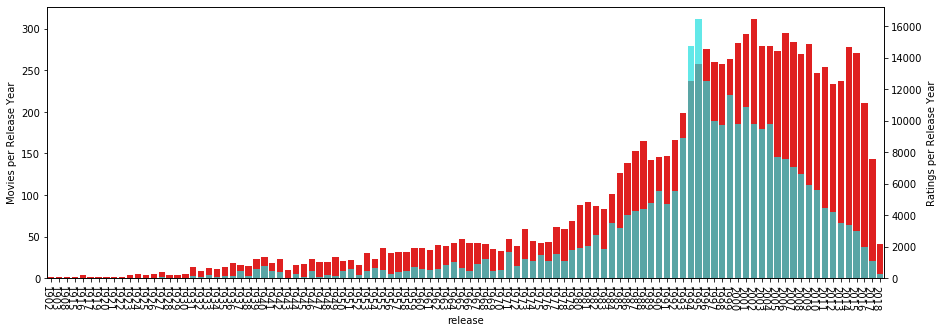

In [247]:
fig, ax = plt.subplots(figsize=(15,5))
sns.countplot(x='release',data=movies_dumb, color='red')
plt.ylabel('Movies per Release Year');
ax2 = ax.twinx()
sns.countplot(x='release', order = sorted(mr['release'].unique()), data=mr, color='cyan', alpha=0.7);
ax.set_xticklabels(ax.get_xticklabels(), rotation=-90, ha="right");
plt.ylabel('Ratings per Release Year');

In [159]:
# describe distribution of # of ratings
# using the dummy var matrix so there's only one line per rating
print(mdr['movieId'].value_counts().describe())

print('\n reviewers: ',len(mdr['userId'].unique()),
      '\n movies: ',len(mdr['movieId'].unique()))


count    9724.000000
mean       10.369807
std        22.401005
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       329.000000
Name: movieId, dtype: float64

 reviewers:  610 
 movies:  9724


Unsurprisingly, there's a imbalance between the number of reviewers and the number of movies -- this is something we should address, if we're looking for relationships between variables.

We can't assume that every movie is equally reviewed, and movies with fewer reviews are less reliable. If I was trying to rank these movies by their average rating, I would probably use a weighted mean that incorpates the number of reviews its gotten. In this case, however, it's probably sufficient to use a minimum number of ratings as a cut-off. I used 50, just as an example for this assessment. 

Regarding the distribution of ratings: I don't expect ratings to be randomly distributed, especially among older movies/classics. Suvivorship bias may come into play; if there's  a movie many people have seen from the 1960s, then that movie is probably well liked and willh ave high ratings (we are less likely to know about bad movies, or have access to them, or have interest in watching them). 

Below, I have looked at the distribution for the most reviewed movies. 

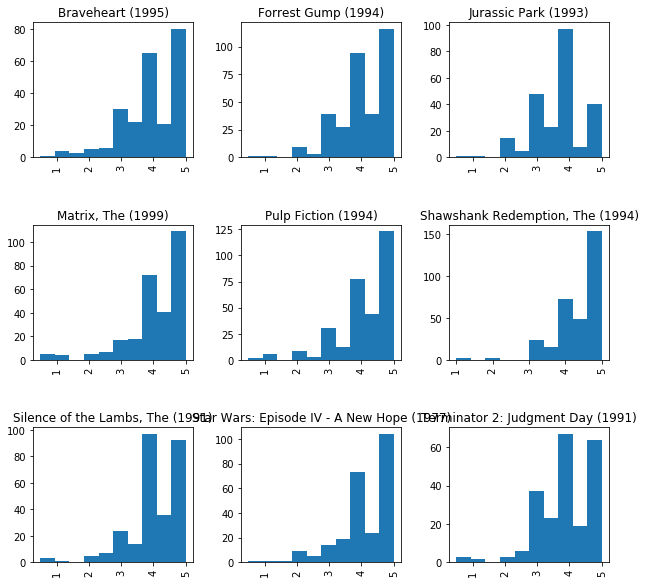

In [275]:
top9=mdr['movieId'].value_counts().sort_values(ascending=False)[:9].index.to_list()
top9_i = [x for (x,j) in enumerate(mdr['movieId']) if ((j in top9))]
mdr.loc[top9_i].hist(by='title',column = 'rating', figsize=(10,10))
plt.show()


## Looking at ratings vs genre, year

In [358]:
genres = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Drama', 'Fantasy', 'Horror', 
       'Romance', 'Sci-Fi', 'Thriller']
movie_data = ['userId', 'movieId', 'rating','release','timestamp']

movie_mean= mdr.groupby([ 'title'], as_index=False)['rating'].agg(['mean', 'std', 'count'])
movie_mean = movie_mean[movie_mean['count']>=50]


mr = mr.loc[mr['genres'].isin(genres)]
gen_yr= mr.groupby([ 'genres', 'release'], as_index=False)['rating'].agg(['mean', 'std', 'count'])
gen_yr=gen_yr[gen_yr['count']>=50]

# Correlated ratings 

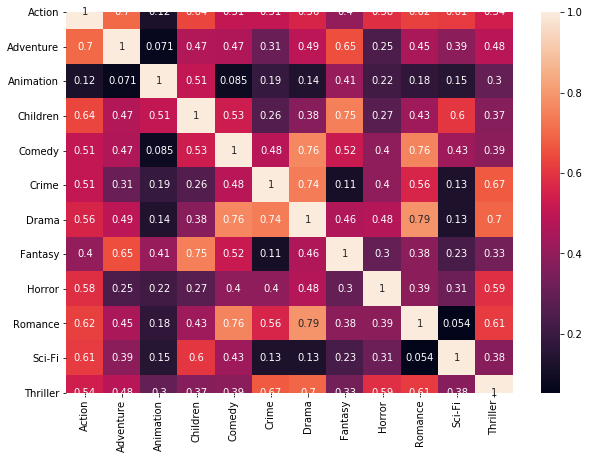

In [341]:
gen_map= pd.DataFrame()

for g in genres:
    gen = gen_yr.loc[g]
    gen_map = pd.concat([gen_map,pd.Series(gen.loc[:]['mean'])], axis=1)
    
gen_map.columns = genres
datty = gen_map.fillna(gen_map.mean())
cory = gen_map.corr()
plt.subplots(figsize=(10,7))
sns.heatmap(cory, annot=True)

#  Mean rating per genre over time

Most important plot!

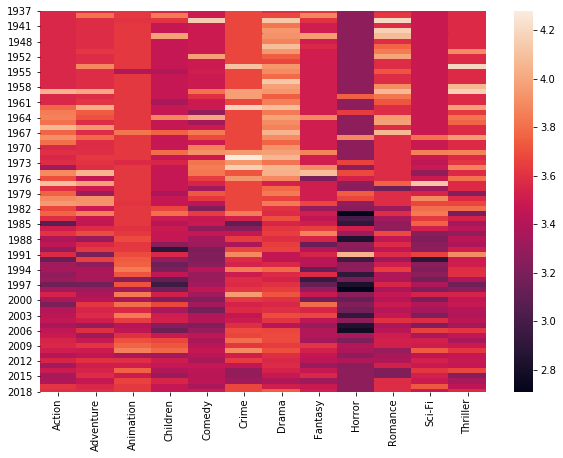

In [346]:
plt.subplots(figsize=(10,7));
ax = sns.heatmap(gen_map.fillna(gen_map.mean()));

I do see low average ratings for Horror in the late 90s/early 00s -- from my childhood I remember there being a plethora of horror movies being released, but that could be my own bias ! Horror also has fewer 'classic' films. Animation does as well, which could be attibuted to technology. I also notice poor-er ratings in Sci-Fi around late 80s/early 90s, as a science fiction fan myself that does make me wonder if there was a bit of a Sci-Fi boom (new Star Trek TNG, technology, etc?) Late 70s/early 80s is also very high for Sci-Fi.

#  Cluster Diagram
to explore relationships between genres furthers

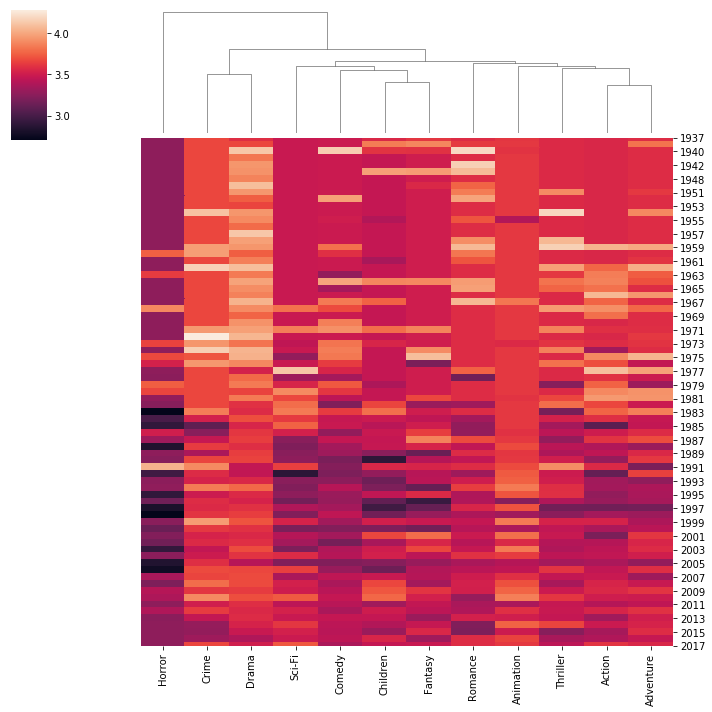

In [353]:
ax = sns.clustermap(gen_map.fillna(gen_map.mean()),row_cluster=False);